<a href="https://colab.research.google.com/github/asgutierrt/Introduction_to_IA/blob/main/unsupervised/no_supervisado_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# run ONCE (only in Colab)
#!git clone https://github.com/asgutierrt/Introduction_to_IA.git
#curr_path="/content/Introduction_to_IA/unsupervised/src"

In [2]:
from pathlib import Path
import os
import plotly.io as pio

# to import from src folder
try:
    os.chdir(curr_path)
    # custom visualization: colab only
    pio.renderers.default='colab'
except:
    os.chdir(os.path.join(Path().absolute().parent,'src'))
    pio.renderers.default='vscode' # other renderers: 'browser', 'jupyterlab', 'notebook'


%load_ext autoreload
%autoreload 2

from modules.load_data import load_data
from modules.distances import plot_distances, get_distance_matrix, covarianza_inversa
from modules.cluster_algorithms import cluster_pipeline, naive_boxes, naive, naive_kn
from modules.support_functions import encode_array


In [23]:
filename = 'water_potability.txt'
#filename='iris'

# load data
X, X_shape = load_data(os.path.join('..','data',filename))
cov_i = covarianza_inversa(X)

exploration of data:

1. number of ocurrences of each class: check for imbalanced data
Potability
0    1998
1    1278

2. basic statistics on the data: check scales of the values and nan value count

                 ph    Hardness        Solids Chloramines     Sulfate Conductivity Organic_carbon Trihalomethanes Turbidity Potability
count        2785.0      3276.0        3276.0      3276.0      2495.0       3276.0         3276.0          3114.0    3276.0     3276.0
mean       7.080795  196.369496  22014.092526    7.122277  333.775777   426.205111       14.28497       66.396293  3.966786    0.39011
std         1.59432   32.879761   8768.570828    1.583085    41.41684    80.824064       3.308162       16.175008  0.780382   0.487849
min             0.0      47.432    320.942611       0.352       129.0   181.483754            2.2           0.738      1.45        0.0
25%        6.093092  176.850538  15666.690297    6.127421  307.699498   365.734414      12.065801       55.844536  3.439711  

In [128]:
import numpy as np
from numpy import linalg as LA

evals , evecs = LA.eig(np.cov(x,rowvar=False))
evals

array([1.83333333e+01, 1.77635684e-15])

In [129]:
np.trace(np.cov(x,rowvar=False))

18.333333333333332

In [90]:
idx = np.argsort(evals)[::-1]
evecs = evecs[:,idx]
evals = evals[idx]

x_p = np.dot(X, evecs) # projection of the data in the new space

array([0.1011339 , 0.09519031, 0.08649584, 0.0783754 , 0.07521051,
       0.07263063, 0.06997035, 0.05000989, 0.04805351])

In [7]:
# store info on report folder
fig_path= os.path.join('..','notebooks','dev_reports','figures')
results_path= os.path.join('..','notebooks','dev_reports','group_matrix')

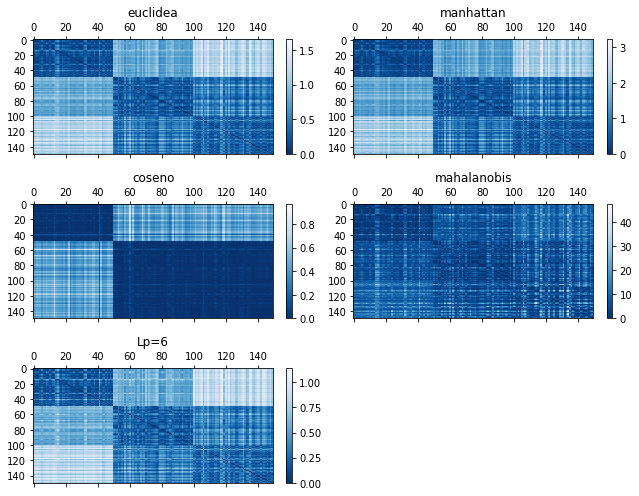

In [10]:
# calculate and plot distances
normas=['euclidea','manhattan','coseno','mahalanobis', 'Lp=6']
D = get_distance_matrix(X,X,cov_i,norms=normas)
plot_distances(D,normas,join(fig_path,'distances_XX.png'))

In [13]:
from itertools import product
import numpy as np

# make grid
N,m=X_shape
malla=lambda m, n_intervals: np.array(list(product(np.arange(n_intervals +1)*1/n_intervals,repeat=m)))
n_grid_intervals= lambda N,m: int(np.exp(np.log(N)/m)-1)
grid=malla(m,n_grid_intervals(N,m))
grid.shape

(81, 4)

c:\Users\anita\Documents\GitHub\Introduction_to_IA\unsupervised\src\modules\distances.py:26: RuntimeWarning:

invalid value encountered in true_divide



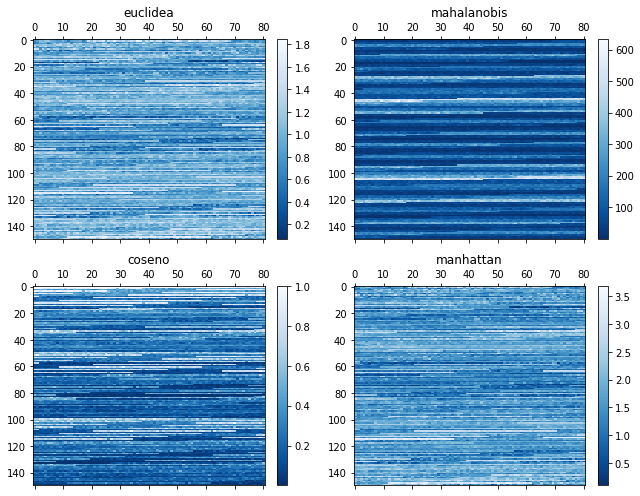

In [14]:
# calculate and plot distances
normas=['euclidea','mahalanobis','coseno','manhattan']
D = get_distance_matrix(X,grid,cov_i,norms=normas)
plot_distances(D,normas,join(fig_path,'distances_XX.png'))

In [16]:
import plotly.graph_objects as go

norma_i=0

fig = go.Figure()

fig.add_scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                  mode='markers',
                  marker=dict(size=5,color='mediumblue'), name='data points')

fig.add_scatter3d(x=grid[:,0], y=grid[:,1], z=grid[:,2],
                  mode='markers', marker=dict(size=5, color='purple'), name='grid points')

# tight layout
fig.update_layout(title_text='naive classes with norm %s: ir cambiando el punto de referencia'%normas[norma_i], 
                  showlegend=False, margin=dict(l=0, r=0, t=40, b=0))
fig.show()

In [ ]:
# readme, requirements.txt: funcionalidad de todo: main (entradas al sistema: archivo de datos), funciones en carpeta src,
# path automatico
# ejm. santiago hincapie, alejandro murillo
# documentar cada funcion y el codigo

In [ ]:
# 5 tipos de clustering en Rn con iris dataset
# 1. leer el archivo: preguntar tipo de archivo (csv,txt,json,xlsx,xls), almacenarlo.
# 1.a. variables categoricas a numericas: crear columnas binarias - onehot encoding
# 2. clustering: matrices de distancias, cajas y k=ki vecinos
# 2.a. n_conjuntos: depende de la segmentacion, parametro default k
# 2.output. matriz Nxki con {0,1}
# - cuenta de a cuales grupos perteneces


In [ ]:
# densidad
# definir la forma del cluster
# subconjunto:
